# Tests de performance application IPS-rest et IPS-graphql

## Préparation : génération de la topologie et fonctions de génération d'intents

Fonctions de création de la topologie avec les APIs Rest et GraphQL :

In [1]:
import requests
from requests.auth import HTTPBasicAuth
import networkx as nx
import matplotlib.pyplot as plt
import time
import itertools
import random
import numpy as np

ip = "127.0.0.1"

def create_graph_graphql(ip):
    global gq_req_size
    # initialisation du graphe
    gr = nx.DiGraph()

    # requêtes au contrôleur ONOS
    url = "http://"+ip+":5000/graphql"
    liens_query = {'query': "query{liens{src,dst}}"}
    host_query = {'query': "query{hosts{id,locations}}"}
    r_hosts = requests.post(url, data = host_query)
    r_links = requests.post(url, data = liens_query)
    gq_req_size = len(r_hosts.content + r_links.content)

    if (r_hosts.status_code != 200):
        return "Erreur sur la liste des hôtes."
    elif (r_links.status_code != 200):
        return "Erreur sur la liste des liens."
    else:
        global host_list_mac_gq
        host_list_mac_gq = []
        host_list = r_hosts.json()['data']['hosts']
        link_list = r_links.json()['data']['liens']
        
        for l in link_list:
            l['src'] = eval(l['src'])
            l['dst'] = eval(l['dst'])
            gr.add_edge(l['src']['device'],l['dst']['device'],orig=l['src']['port'],dest=l['dst']['port'])
            gr.add_edge(l['dst']['device'],l['src']['device'],orig=l['dst']['port'],dest=l['src']['port'])
        
        for h in host_list:
            h['locations'] = list(eval(h['locations']))
            gr.add_node(h['id'],id=h['id'])
            host_list_mac_gq.append(h['id'])
            gr.add_edge(h['id'],h['locations'][0]["elementId"],orig="host",dest=h['locations'][0]["port"])
            gr.add_edge(h['locations'][0]["elementId"],h['id'],orig=h['locations'][0]["port"],dest="host")
        
        return gr
    
def create_graph_rest(ip):
    global rest_req_size
    # initialisation du graphe
    gr = nx.DiGraph()

    # requêtes au contrôleur ONOS
    r_host = requests.get("http://"+ip+":5000/rest/hosts")
    r_link = requests.get("http://"+ip+":5000/rest/links")
    rest_req_size = len(r_host.content + r_link.content)
    if (r_host.status_code != 200):
        return "Erreur sur la liste des hôtes."
    elif (r_link.status_code != 200):
        return "Erreur sur la liste des liens."
    else:
        global host_list_mac_re
        host_list_mac_re = []
        host_list = r_host.json()
        link_list = r_link.json()
        
        for l in link_list:
            gr.add_edge(l['src']['device'],l['dst']['device'],orig=l['src']['port'],dest=l['dst']['port'])
            gr.add_edge(l['dst']['device'],l['src']['device'],orig=l['dst']['port'],dest=l['src']['port'])
        
        for h in host_list:
            gr.add_node(h['id'],id=h['id'])
            host_list_mac_re.append(h['id'])
            gr.add_edge(h['id'],h['locations'][0]["elementId"],orig="host",dest=h['locations'][0]["port"])
            gr.add_edge(h['locations'][0]["elementId"],h['id'],orig=h['locations'][0]["port"],dest="host")
        
        return gr

Fonctions de génération d'intents

In [2]:
def calcul_taille_requete(req):
    method_len = len(req.request.method)
    url_len = len(req.request.url)
    headers_len = len('\r\n'.join('{}{}'.format(k, v) for k, v in req.request.headers.items()))
    body_len = len(req.request.body if req.request.body else [])
    return method_len+url_len+headers_len+body_len

def install_intent_re(gr_rest,mac_o,mac_d,liste_chemin,count):
    global size_req_re
    
    l=liste_chemin
    fwd_orig = ("","")
    fwd_dest = ("","")
    mac_orig = mac_o.replace("/None","")
    mac_dest = mac_d.replace("/None","")
    for i in range(0,len(l)-1):
        if i==len(l)-2:
            port = gr_rest.get_edge_data(l[i],l[i+1])
            fwd_dest = (l[i],port["orig"])
            intent_orig = fwd_orig[0]+"-"+fwd_orig[1]
            intent_dest = fwd_dest[0]+"-"+fwd_dest[1]
            
            r_intent = requests.get("http://"+ip+":5000/rest/intent?orig="+intent_orig+"&dest="+intent_dest
            +"&macorig="+mac_orig+"&macdest="+mac_dest)
            r_intent_inv = requests.get("http://"+ip+":5000/rest/intent?orig="+intent_dest+"&dest="+intent_orig
            +"&macorig="+mac_dest+"&macdest="+mac_orig)

            size_req_re += calcul_taille_requete(r_intent)+calcul_taille_requete(r_intent_inv)
            # size_send_re += int(r_intent.headers['Content-Length']) + int(r_intent_inv.headers['Content-Length'])
            # size_rece_re += len(r_intent.content + r_intent_inv.content)

            count += 2
        else:
            port = gr_rest.get_edge_data(l[i],l[i+1])
            if (port["orig"]=="host"):
                fwd_orig = (l[i+1],port["dest"])
            else:
                fwd_dest = (l[i],port["orig"])
                if (port["orig"]!="host"):
                    intent_orig = fwd_orig[0]+"-"+fwd_orig[1]
                    intent_dest = fwd_dest[0]+"-"+fwd_dest[1]
                    
                    r_intent = requests.get("http://"+ip+":5000/rest/intent?orig="+intent_orig+"&dest="+intent_dest
                    +"&macorig="+mac_orig+"&macdest="+mac_dest)
                    r_intent_inv = requests.get("http://"+ip+":5000/rest/intent?orig="+intent_dest+"&dest="+intent_orig
                    +"&macorig="+mac_dest+"&macdest="+mac_orig)

                    size_req_re += calcul_taille_requete(r_intent)+calcul_taille_requete(r_intent_inv)
                    # size_send_re += int(r_intent.headers['Content-Length']) + int(r_intent_inv.headers['Content-Length'])
                    # size_rece_re += len(r_intent.content + r_intent_inv.content)
                    count += 2

                    fwd_orig = (l[i+1],port["dest"])
                else:
                    fwd_orig = ("","")
    return count

def install_intent_gq(gr_graphql,mac_o,mac_d,liste_chemin):
    l=liste_chemin
    fwd_orig = ("","")
    fwd_dest = ("","")
    mac_orig = mac_o.replace("/None","")
    mac_dest = mac_d.replace("/None","")
    # string_mut="mutation { addIntent2(input: "
    liste_intents = []
    
    for i in range(0,len(l)-1):
        if i==len(l)-2:
            port = gr_graphql.get_edge_data(l[i],l[i+1])
            fwd_dest = (l[i],port["orig"])
            intent_orig = fwd_orig[0]+"/"+fwd_orig[1]
            intent_dest = fwd_dest[0]+"/"+fwd_dest[1]
            liste_intents.append("{intentOrig: \""+intent_orig+"\", macOrig: \""+mac_orig+"\", intentDest: \""+intent_dest+"\", macDest: \""+mac_dest+"\"}")
            liste_intents.append("{intentOrig: \""+intent_dest+"\", macOrig: \""+mac_dest+"\", intentDest: \""+intent_orig+"\", macDest: \""+mac_orig+"\"}")
        else:
            port = gr_graphql.get_edge_data(l[i],l[i+1])
            if (port["orig"]=="host"):
                fwd_orig = (l[i+1],port["dest"])
            else:
                fwd_dest = (l[i],port["orig"])
                if (port["orig"]!="host"):
                    intent_orig = fwd_orig[0]+"/"+fwd_orig[1]
                    intent_dest = fwd_dest[0]+"/"+fwd_dest[1]

                    liste_intents.append("{intentOrig: \""+intent_orig+"\", macOrig: \""+mac_orig+"\", intentDest: \""+intent_dest+"\", macDest: \""+mac_dest+"\"}")
                    liste_intents.append("{intentOrig: \""+intent_dest+"\", macOrig: \""+mac_dest+"\", intentDest: \""+intent_orig+"\", macDest: \""+mac_orig+"\"}")

                    fwd_orig = (l[i+1],port["dest"])
                else:
                    fwd_orig = ("","")
    return liste_intents

def liste_couples_res():
    liste_couples = list(itertools.combinations(host_list_mac_re, 2))
    liste_res = []

    global ent
    ent = np.floor(len(liste_couples)/10).astype(int)
    for i in range(1,11):
        liste_res.append(random.choices(liste_couples, k=ent*i))
    return liste_res

def do_install_intent(gr_rest,gr_graphql):
    global size_send_gq,size_rece_gq

    temps_re = []
    temps_gq = []

    count_re = []
    count_gq = []

    liste_couples = liste_couples_res()

    for i in liste_couples:
        count = 0
        start = time.time()
        for elt in i:
            # clean = requests.get("http://"+ip+":5000/removeIntents")
            count = install_intent_re(gr_rest,elt[0],elt[1],nx.shortest_path(gr_rest,elt[0],elt[1]),count)
        end = time.time()
        temps_re.append(round(end-start,1))
        count_re.append(count)

    for i in liste_couples:
        res = []
        for elt in i:
            res.append(install_intent_gq(gr_graphql,elt[0],elt[1],nx.shortest_path(gr_graphql,elt[0],elt[1])))
        
        flatten = itertools.chain.from_iterable
        res = list(flatten(res))

        string_mut ="mutation MyMutation { addIntent(intentList: "
        string_mut += "["+",".join(res)+"]) { ok } }"

        mutation_query = {'query': string_mut}
        # print(mutation_query)
        start = time.time()
        query_gql = requests.post("http://"+ip+":5000/graphql", data = mutation_query)
        print(query_gql.content)
        end = time.time()

        global size_req_gq 
        size_req_gq = calcul_taille_requete(query_gql)
        # size_send_gq += int(query_gql.headers['Content-Length'])
        # size_rece_gq += len(query_gql.content)
        temps_gq.append(round(end-start,1))
        count_gq.append(count)

    return [temps_re,temps_gq,count_re,size_req_re,size_req_gq]

def trace_resultats(l):
    pourc = []
    for i in range(0,10):
        pourc.append((l[0][i]-l[1][i])*100/l[0][i])
    print(pourc)
    print(np.mean(pourc))

    labels = []
    for i in range(1,11):
        labels.append(str(ent*i))

    x = np.arange(len(labels))
    width = 0.42

    fig, ax = plt.subplots(figsize=(17,8))
    fig2, ax2 = plt.subplots(figsize=(17,8))

    rects1 = ax.bar(x - width/2, l[0], width, label='Rest')
    rects2 = ax.bar(x + width/2, l[1], width, label='GraphQL')

    rects3 = ax2.bar(x, l[2], width, label='Rest')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Nombre de couples générés')
    ax.set_ylabel('Temps en secondes')
    ax.set_title('Temps de génération des intents')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1)
    ax.bar_label(rects2)

    fig.tight_layout()

    ax2.set_xlabel('Nombre de couples générés')
    ax2.set_ylabel('Nombre de requêtes')
    ax2.set_title('Nombre de requêtes nécessaires à la génération des intents')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.legend()

    ax2.bar_label(rects3)

    fig2.tight_layout()

    plt.rcParams["font.size"] = "20"
    plt.show()

## Tests : méthode

- on compte le nombre d'hôtes N de la topologie : le nombre de paires d'hôtes à relier au total est alors T = N*(N-1)/2
- on calcule une liste L de 10 nombres Ti régulièrement espacés de paires d'hôtes à relier, qui seront choisis au hasard parmi la liste de toutes les paires d'hôtes de la topologie
- pour chaque liste de paires d'hôtes à relier, on installe les intents nécessaires pour router correctement tous les paquets entre chaque paire d'hôte

### T1 : topologie torus,3,3 : 9 hôtes, 36 liens

In [18]:
gq_req_size = 0
rest_req_size = 0
size_req_re = 0
size_req_gq = 0

gr_rest = create_graph_rest(ip)
gr_graphql = create_graph_graphql(ip)

l = do_install_intent(gr_rest,gr_graphql)
print(l)

b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
[[1.1, 2.0, 2.7, 3.9, 4.4, 5.6, 6.2, 7.6, 8.4, 8.6], [0.8, 1.3, 2.1, 2.9, 3.4, 4.1, 4.6, 5.4, 6.2, 6.3], [18, 32, 44, 64, 74, 90, 102, 124, 136, 138], 194814, 27735]


[27.272727272727273, 35.0, 22.222222222222225, 25.641025641025642, 22.727272727272734, 26.78571428571429, 25.806451612903235, 28.947368421052627, 26.190476190476193, 26.744186046511626]
26.733744441990588


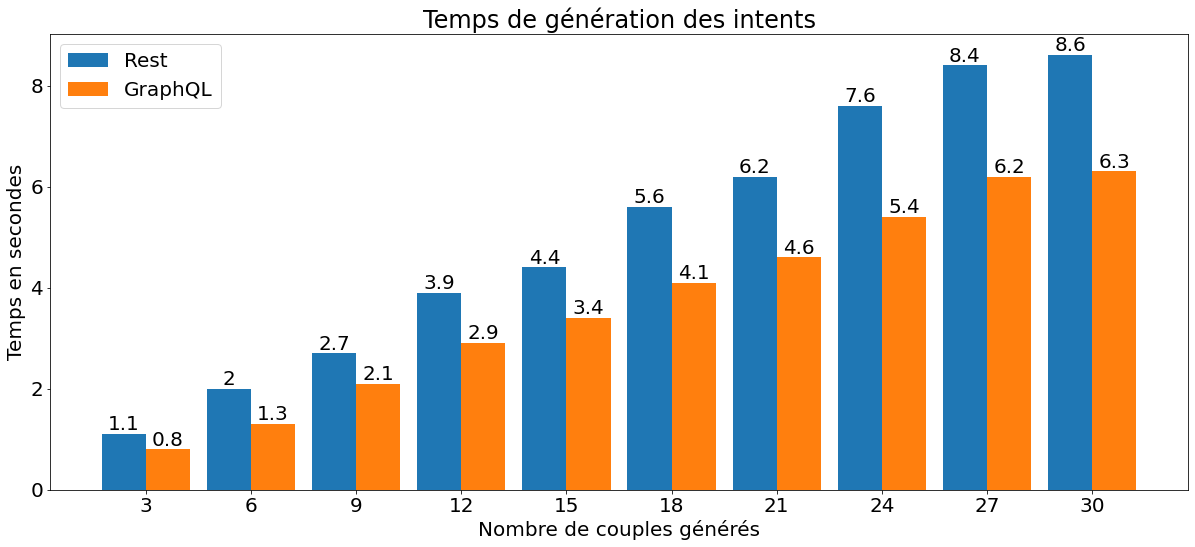

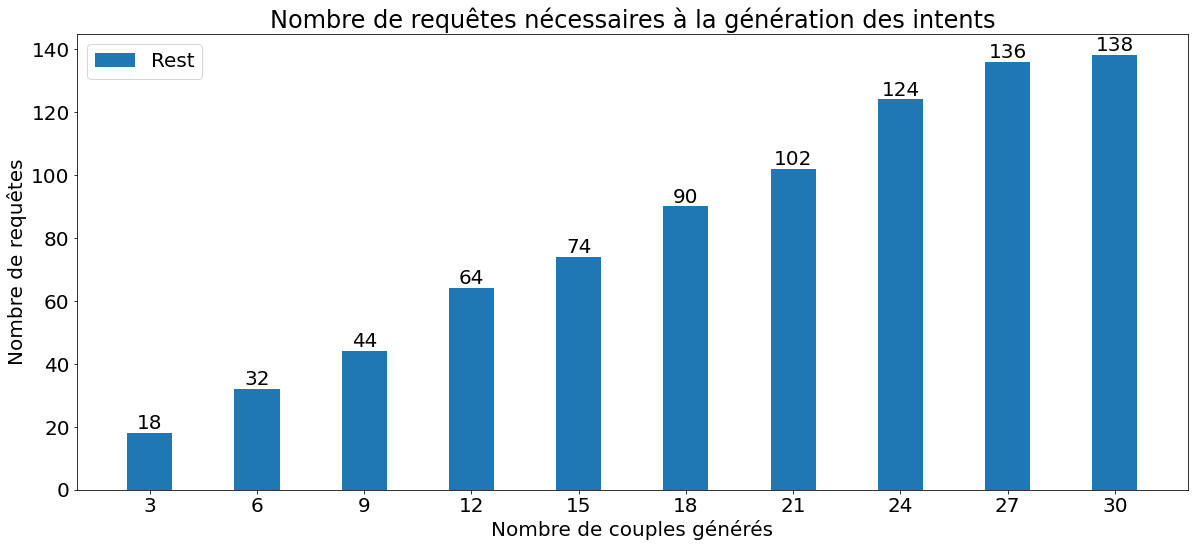

In [19]:
trace_resultats(l)

### T2 : topologie torus,4,4 : 16 hôtes, 64 liens

In [20]:
gq_req_size = 0
rest_req_size = 0
size_send_re = 0
size_rece_re = 0
size_send_gq = 0
size_rece_gq = 0

gr_rest = create_graph_rest(ip)
gr_graphql = create_graph_graphql(ip)

l2 = do_install_intent(gr_rest,gr_graphql)
print(l2)

b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
[[3.9, 9.7, 13.7, 19.0, 23.2, 27.0, 34.7, 39.1, 43.6, 49.1], [2.8, 7.3, 10.2, 14.0, 16.9, 19.8, 24.9, 27.7, 30.9, 36.8], [62, 156, 218, 300, 362, 422, 540, 604, 680, 764], 1168410, 152310]


[28.205128205128208, 24.74226804123711, 25.547445255474454, 26.31578947368421, 27.15517241379311, 26.66666666666666, 28.2420749279539, 29.15601023017903, 29.12844036697248, 25.050916496945018]
27.020991207803416


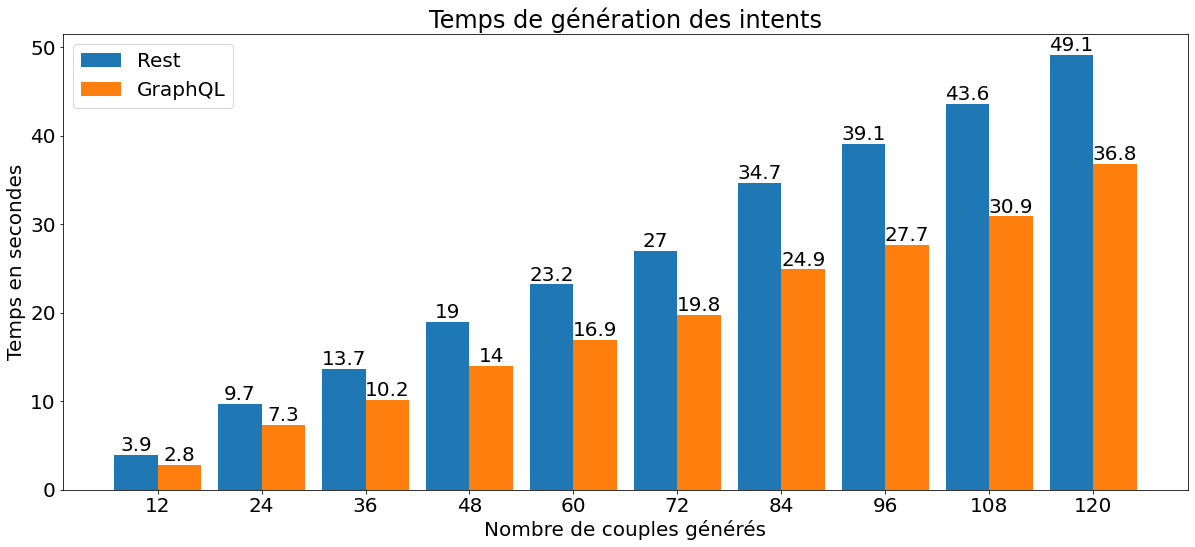

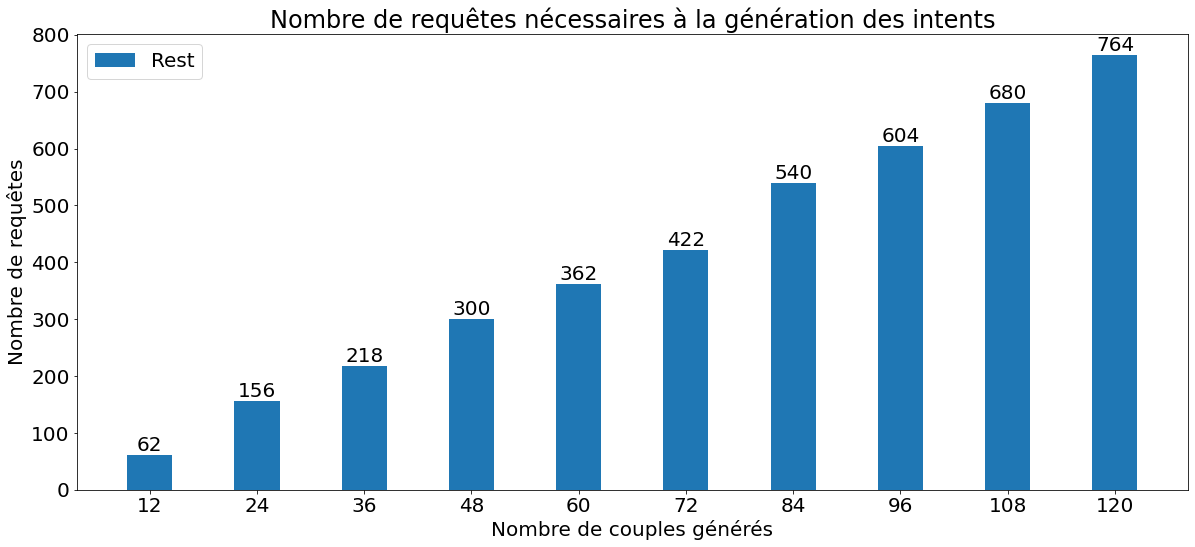

In [21]:
trace_resultats(l2)

### T3 : topologie tree,d4,f2 : 16 hôtes, 28 liens

In [23]:
gq_req_size = 0
rest_req_size = 0
size_req_re = 0
size_req_gq = 0

gr_rest = create_graph_rest(ip)
gr_graphql = create_graph_graphql(ip)

l3 = do_install_intent(gr_rest,gr_graphql)
print(l3)

b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
[[8.3, 16.6, 21.7, 32.1, 40.9, 50.3, 59.6, 70.4, 75.1, 86.1], [6.3, 12.7, 16.0, 24.4, 30.6, 36.7, 44.3, 52.6, 55.4, 65.0], [132, 268, 344, 516, 640, 792, 940, 1116, 1180, 1348], 1724412, 268526]


[24.096385542168683, 23.49397590361447, 26.26728110599078, 23.987538940809976, 25.18337408312958, 27.037773359840948, 25.671140939597322, 25.284090909090914, 26.231691078561912, 24.506387921022064]
25.175963978382665


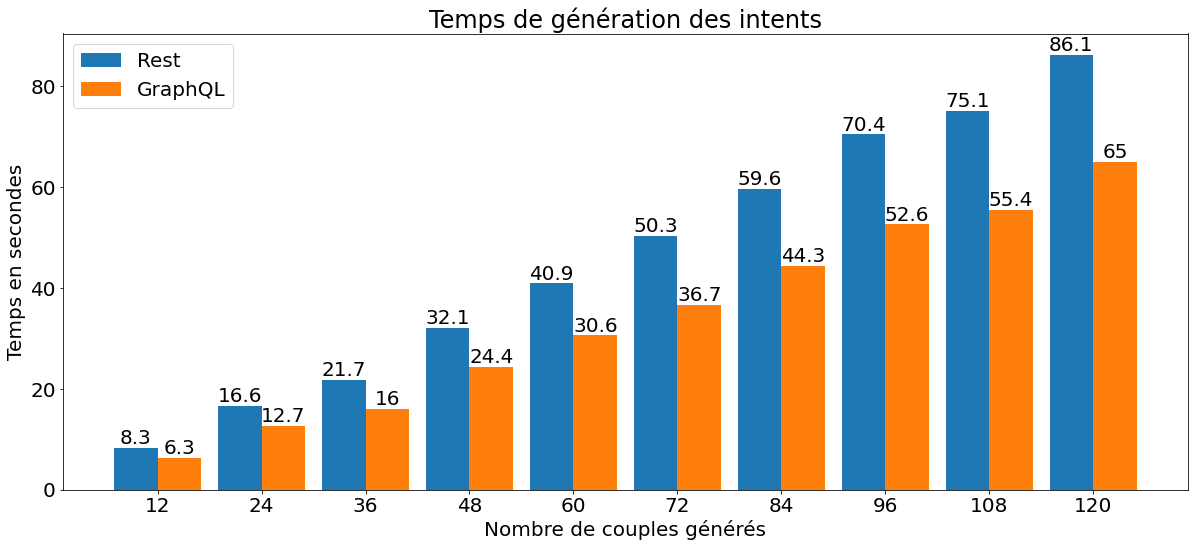

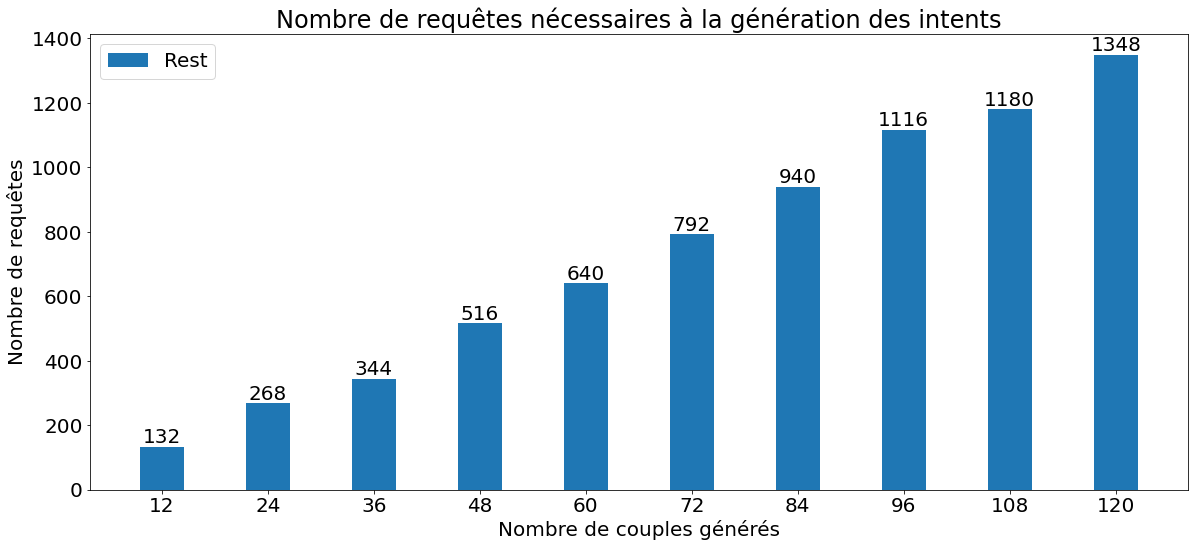

In [24]:
trace_resultats(l3)

### T4 : topologie tree,d4,f3 : 16 hôtes, 28 liens

In [23]:
gq_req_size = 0
rest_req_size = 0
size_req_re = 0
size_req_gq = 0

gr_rest = create_graph_rest(ip)
gr_graphql = create_graph_graphql(ip)

l4 = do_install_intent(gr_rest,gr_graphql)
print(l4)

b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
[[8.3, 16.6, 21.7, 32.1, 40.9, 50.3, 59.6, 70.4, 75.1, 86.1], [6.3, 12.7, 16.0, 24.4, 30.6, 36.7, 44.3, 52.6, 55.4, 65.0], [132, 268, 344, 516, 640, 792, 940, 1116, 1180, 1348], 1724412, 268526]


[24.096385542168683, 23.49397590361447, 26.26728110599078, 23.987538940809976, 25.18337408312958, 27.037773359840948, 25.671140939597322, 25.284090909090914, 26.231691078561912, 24.506387921022064]
25.175963978382665


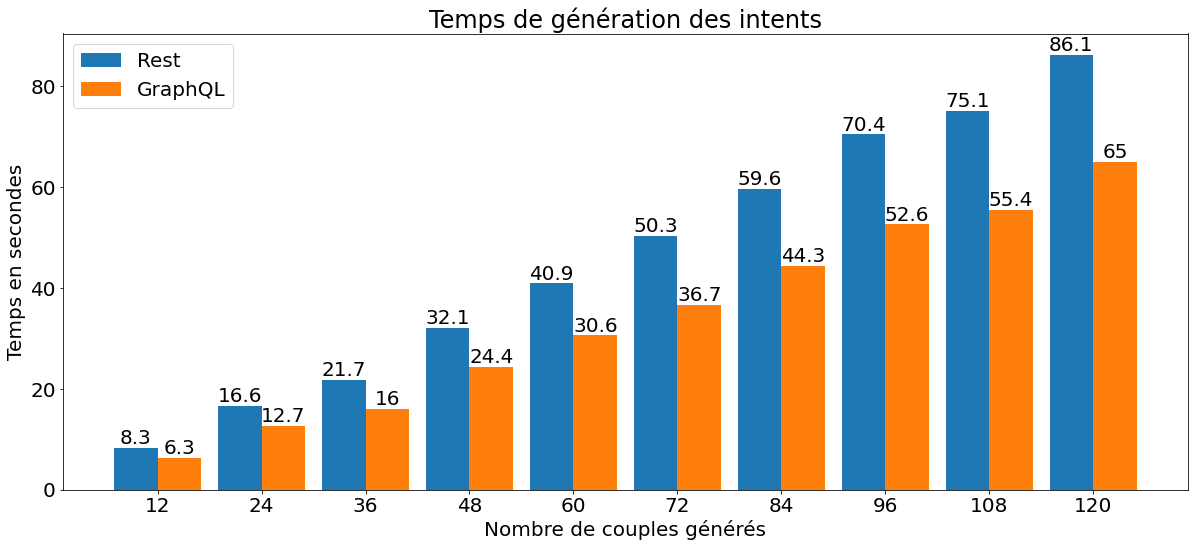

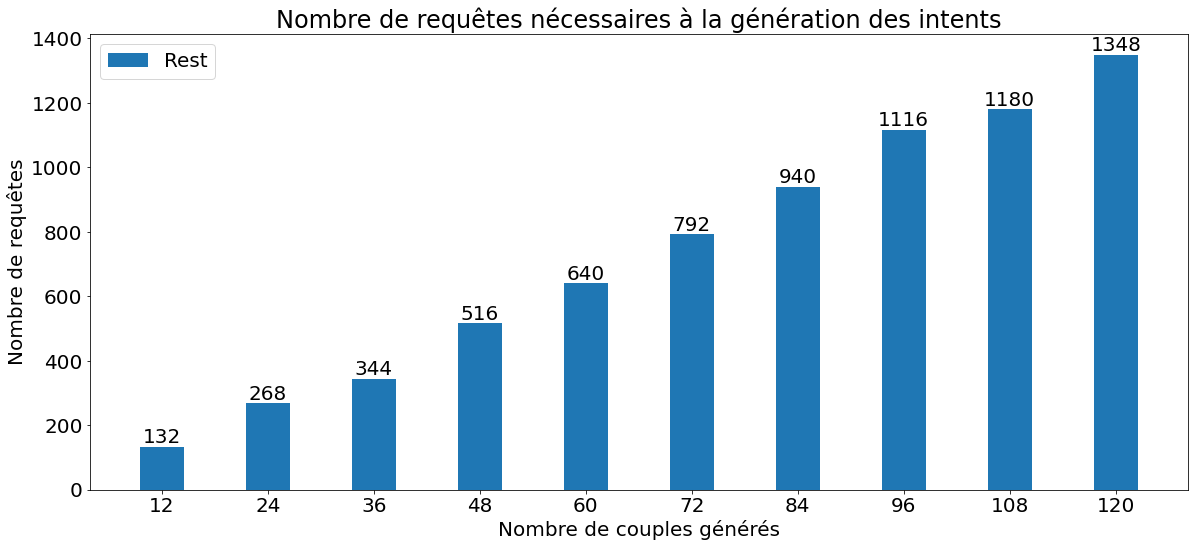

In [24]:
trace_resultats(l4)

T5 : topologie Renater : 44 hôtes, 112 liens

In [4]:
gq_req_size = 0
rest_req_size = 0
size_req_re = 0
size_req_gq = 0

gr_rest = create_graph_rest(ip)
gr_graphql = create_graph_graphql(ip)

l5 = do_install_intent(gr_rest,gr_graphql)
print(l5)

b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
[[51.1, 108.6, 159.5, 223.5, 280.4, 312.5, 370.8, 423.6, 478.5, 537.6], [35.9, 77.0, 115.2, 164.3, 190.1, 234.1, 283.6, 298.4, 342.2, 386.7], [848, 1788, 2602, 3542, 4394, 5304, 6200, 6982, 7938, 8842], 11482022, 1760135]


[29.745596868884544, 29.097605893186, 27.774294670846395, 26.48769574944071, 32.203994293865904, 25.088000000000005, 23.516720604099238, 29.556185080264406, 28.484848484848488, 28.069196428571434]
28.002413807400718


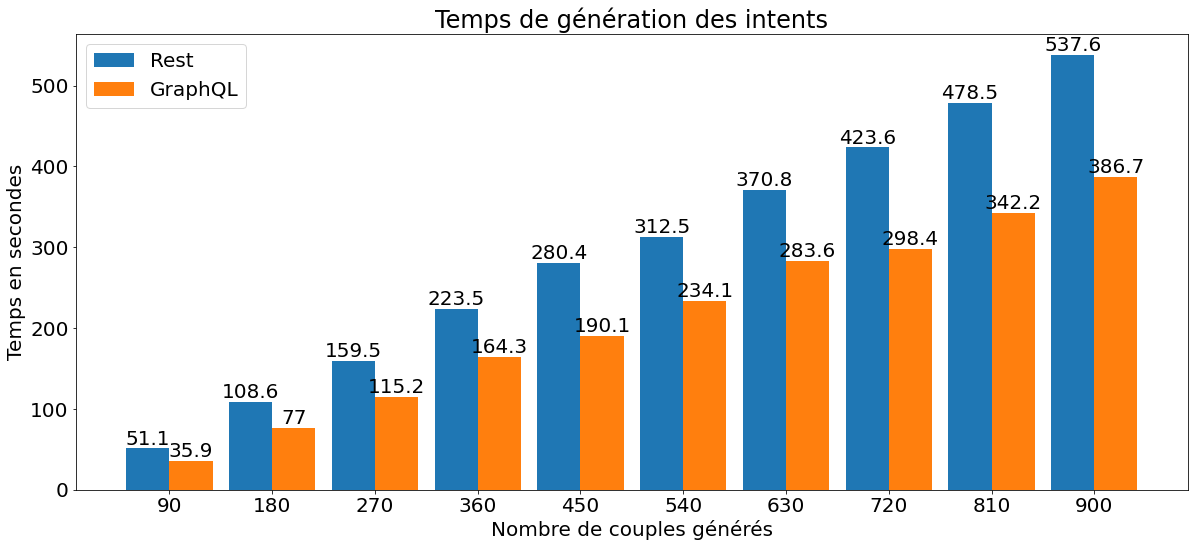

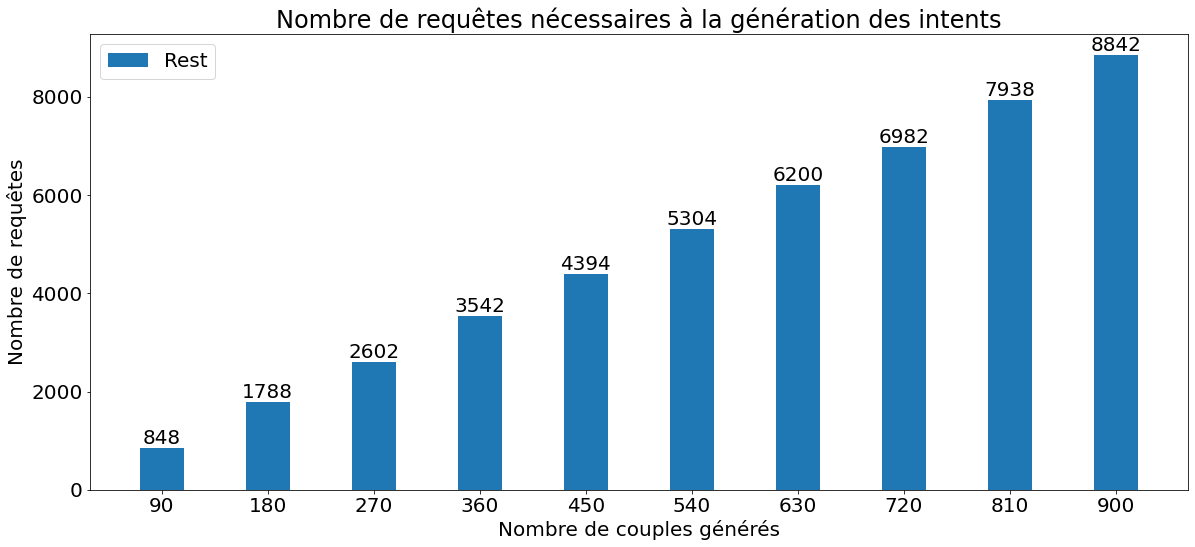

In [6]:
trace_resultats(l5)

### TB - Comparaison de la taille des requêtes selon la topologie

In [7]:
taille_req_re = [l[3],l2[3],l3[3],l4[3],l5[3]]
taille_req_gq = [l[4],l2[4],l3[4],l4[4],l5[3]]

for i in range(0,len(taille_req_gq)):
    taille_req_gq[i] /= 1000
    taille_req_re[i] /= 1000

topo = ["torus 3x3", "torus 4x4","tree,d4,f2","tree,d4,f3","renater"]

labels = ["torus 3x3","torus 4x4","tree,d4,f2","tree,d4,f3","renater"]

x = np.arange(len(labels))
width = 0.42

fig3, ax3 = plt.subplots(figsize=(17,8))

rects1 = ax3.bar(x - width/2, taille_req_re, width, label='Rest')
rects2 = ax3.bar(x + width/2, taille_req_gq, width, label='GraphQL')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax3.set_xlabel('Topologie')
ax3.set_ylabel('Taille des requêtes (en Ko)')
ax3.set_title('Taille des requêtes transmises en fonction de la topologie')
ax3.set_xticks(x)
ax3.set_xticklabels(labels)
ax3.legend()

ax3.bar_label(rects1)
ax3.bar_label(rects2)

fig3.tight_layout()

plt.rcParams["font.size"] = "20"
plt.show()

NameError: name 'l' is not defined